<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's install and upgrade the necessary packages

In [1]:
# Install the latest version of TensorFlow, which includes Keras (tf.keras)
!pip install tensorflow --upgrade
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

Let's import all the necessary functions and packages

In [2]:
!git clone https://github.com/DarioMameli/DL_Datasets
import sys
sys.path.insert(1, '/content/DL_Datasets/')

fatal: destination path 'DL_Datasets' already exists and is not an empty directory.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from keras import backend as backend
from keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from dl_utils import plot_history
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from google.colab import files

Check the versions of the packages

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


Check the runtime device

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

Load the training and test set and display its shape

In [4]:
# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/DL_Datasets/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Sort the list of files to ensure a consistent order
        #file_list = sorted(os.listdir(folder_path))

        # Iterate through sorted images in each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to a numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resizing all the images
resized_images = []
# Define the target size
width = 224
height = 224
target_size = (width, height)

# Resize each image to the target size using LANCZOS resampling
for img in X:
    resized_img = img.resize(target_size, Image.LANCZOS)
    resized_images.append(resized_img)
# Convert the list of resized images to a NumPy array
X_array = np.array([np.array(img) for img in resized_images])
#plt.imshow(X_array[1000])
#plt.title(y[1000])
#plt.show()
#plt.imshow(X_array[500])
#plt.title(y[500])
#plt.show()
#plt.imshow(X_array[0])
#plt.title(y[0])
#plt.show()

In [5]:
SEED=33

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.1, shuffle=True, random_state=SEED)

Preprocess the feature vectors (normalize data)

In [6]:
# Input data preprocessing
#print(np.min(X_train), np.max(y_train))
#X_train = X_train.astype("float32")
#X_test = X_test.astype("float32")

#normalization
#X_train /= 255
#X_test /= 255

X_train = keras.applications.resnet50.preprocess_input(X_train)

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")


1298 train samples
145 test samples


Preprocess the labels (one-hot encodings)

In [7]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 4
First label is now =  [0. 0. 0. 0. 1.]


## Validation data
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [8]:
# Split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED) # for reproducibility

##Build a Baseline model

In [9]:
def CNNModel(num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
num_classes = 5
model = CNNModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 222, 222, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 222, 222, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 222, 222, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 512)       │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 222, 222, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,389 (2.64 MB)

 Trainable params: 691,365 (2.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

##Our Model

In [9]:
class MyCNNModel(kt.HyperModel):
    def __init__(self, loss="categorical_crossentropy"):
        self.loss = loss

    def build(self, hp):
        model = self.build_CNN(hp)
        return model

    def build_CNN(self, hp):
        hp_units = hp.Choice('units', values=[16, 32, 64, 128])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
        hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.6, step=0.2)

        model = self.build_CNN_hp(
            hp_units=hp_units, hp_learning_rate=hp_learning_rate,
            hp_dropout_rate=hp_dropout_rate
        )
        return model

    def build_CNN_hp(self, hp_units, hp_learning_rate,
                     hp_dropout_rate):

        backend.clear_session()

        #pretrained network ResNet50
        resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=num_classes)

        for layer in resnet.layers:
            layer.trainable = False

        x = resnet.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(hp_units*2, activation='relu')(x)
        x = Dropout(hp_dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(hp_units, activation='relu')(x)
        x = Dropout(hp_dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(units=5, activation='softmax')(x)

        # Create the final model
        dnn_model = Model(inputs=resnet.input, outputs=x)

        optimizer = Adam(learning_rate=hp_learning_rate)

        #print(dnn_model.summary())

        dnn_model.compile(optimizer=optimizer, loss=self.loss, metrics=["accuracy"])

        return dnn_model

    def fit(self, hp, model, *args, **kwargs):
        datagen_train = ImageDataGenerator(
          rescale=1./255,
          zoom_range=(0.8, 1.2),
          vertical_flip=True
        )

        datagen_train.fit(X_train)

        datagen_val = ImageDataGenerator(
          rescale=1./255,
          zoom_range=(0.8, 1.2),
          vertical_flip=True,
        )

        datagen_val.fit(X_val)

        return model.fit(
            datagen_train.flow(X_train, y_train, batch_size=128, shuffle=True),
            validation_data=datagen_val.flow(X_val, y_val, batch_size=128, shuffle=True)
        )


In [10]:
# Define the hyperband tuner object, passing the model where to perform the search
#tuner = kt.Hyperband(MyCNNModel(),
#                     objective='val_accuracy',
#                     max_epochs=10,
#                     overwrite=True,
#                     max_consecutive_failed_trials=5,
#                     project_name='my_cnn_tuning',
#                     directory='my_cnn_tuning',
#)
tuner = kt.BayesianOptimization(
    hypermodel=MyCNNModel(),
    objective='val_accuracy',
    overwrite=True,
    max_trials=10,
    directory='my_cnn_tuning',
    project_name='my_cnn_tuning'
)

# Summarize the search space
tuner.search_space_summary()


Search space summary
Default search space size: 3
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-05, 1e-06], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.2, 'sampling': 'linear'}


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

In [ ]:
batch_size = 128
epochs = 15

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
plot_history(history)

Epoch 1/15


UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-386b966f3443>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.19 = (f32[128,512,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,128,222,222]{3,2,1,0} %select.82, f32[512,128,3,3]{3,2,1,0} %transpose.102, f32[512]{0} %arg15.16), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_4_1/convolution" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 12936282112 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_3224]

Save the baseline model in the workspace

In [ ]:
model.save('/content/baseline_model.keras')
files.download('/content/baseline_model.keras')

## Training the best model


In [ ]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=5,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=3,
)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for maximum 50 epochs
best_model = tuner.hypermodel.build(best_hps)

# Delete tuner to free memory
del tuner

#train the model with the whole data set
#we should eliminate the validation state since it is not useful anymore
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

# Plot the training summary
plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Trial 10 Complete [00h 01m 36s]
val_accuracy: 0.1846153885126114

Best val_accuracy So Far: 0.2230769246816635
Total elapsed time: 00h 11m 17s
Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 518ms/step - accuracy: 0.2023 - loss: 2.2022 - val_accuracy: 0.1654 - val_loss: 1.7814
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.1919 - loss: 2.1165 - val_accuracy: 0.1538 - val_loss: 1.6990
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.2095 - loss: 2.0556 - val_accuracy: 0.1731 - val_loss: 1.6577
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.2304 - loss: 1.9968 - val_accuracy: 0.2077 - val_loss: 1.6274
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.2100 - loss: 2.0502 - val_accuracy: 0.2385 - val_loss: 1.5967
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.2345 - loss: 1.9680 - val_accuracy: 0.2615 - val_loss: 1.5655
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.2355 - loss: 1.9044 - 

Save the best model in the workspace

In [ ]:
best_model.save('/content/best_model.keras')
files.download('/content/best_model.keras')

#Evaluation


## Baseline evaluation

Print the loss and accuracy of the trained baseline model.

In [ ]:
base_score = model.evaluate(X_test, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

## Best model evaluation
Print the best hyperparameters found by the hyperband tuner.

Print the loss and accuracy of the best model.

Print the accuracy increment in the test set.

The test set is not subject to augmentation as it should not be manipulated, but only be used as references for evaluation.

In [ ]:
best_score = best_model.evaluate(X_test, y_test, verbose=0)

# Evaluate and print results
best_score = best_model.evaluate(X_test, y_test, verbose=0)
print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

##Pretrained network

In [ ]:
#del model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
#modify the dimensions of the images to adapt to the input of the neural network

#pretrained network ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(units=5, activation='softmax')(x)

# Create the final model
dnn_model = Model(inputs=resnet.input, outputs=x)

print(dnn_model.summary())

dnn_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,163,717 (92.18 MB)

 Trainable params: 571,013 (2.18 MB)

 Non-trainable params: 23,592,704 (90.00 MB)

None


In [ ]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=10,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=5,
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(0.8, 1.2),
    vertical_flip=True,
    )

val_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(0.8, 1.2),
    vertical_flip=True,
    )

train_generator = train_datagen.flow(X_train, y_train, batch_size=128, shuffle=True)

validation_generator = val_datagen.flow(X_val, y_val, batch_size=128, shuffle=True)

# Adjust epochs and steps_per_epoch based on your dataset size
history = dnn_model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[stop_early])

dnn_model.save('/content/dnn_model.keras')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.2223 - loss: 1.9939 - val_accuracy: 0.1808 - val_loss: 1.6384
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - accuracy: 0.2713 - loss: 1.9536 - val_accuracy: 0.1808 - val_loss: 1.6524
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2850 - loss: 1.7828 - val_accuracy: 0.1808 - val_loss: 1.6603
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2890 - loss: 1.8695 - val_accuracy: 0.1808 - val_loss: 1.5851
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 880ms/step - accuracy: 0.2952 - loss: 1.8949 - val_accuracy: 0.1808 - val_loss: 1.6657
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3319 - loss: 1.7131 - val_accuracy: 0.1808 - val_loss: 1.6710
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3497 - loss: 1.7197 - val_accuracy: 0.1808 - val_loss: 1.5797
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3587 - loss: 1.5729 - val_accuracy: 0.1808 - val_loss: 1.6533
Epoch 9/50
9/

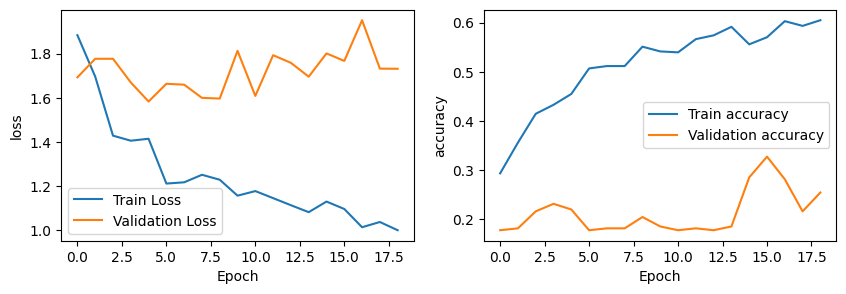

In [ ]:
# Plot the training summary
plot_history(history)

##Pretrained Model evaluation

We define a function to compute class-wise accuracies given a model and the testing data.

In [ ]:
def compute_class_accuracies(X_data, y_data, model):
  # The predicted probabilities for each class
  y_pred_probs = model.predict(X_data)

  # The corresponding predicted labels
  y_pred_labels = np.argmax(y_pred_probs, axis=1)

  # The corresponding true labels
  y_true_labels = np.argmax(y_data, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_true_labels, y_pred_labels)

  # Compute accuracies and weights for each class
  class_accuracies = []
  for class_label in range(len(cm)):
      class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
      class_accuracies.append(class_accuracy)

  # Print the classification report
  print(classification_report(y_true_labels, y_pred_labels))

  return class_accuracies


Here we compute the class accuracies and F1.

In [ ]:
# Compute class-wise accuracies of the best_model
class_accuracies = compute_class_accuracies(X_test, y_test, dnn_model)

# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        35
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        16
           4       0.21      0.91      0.34        23

    accuracy                           0.31       145
   macro avg       0.15      0.32      0.19       145
weighted avg       0.16      0.31      0.20       145

Class 0: Accuracy 0.69
Class 1: Accuracy 0.00
Class 2: Accuracy 0.00
Class 3: Accuracy 0.00
Class 4: Accuracy 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
best_score = dnn_model.evaluate(X_test, y_test, verbose=0)

# Evaluate and print results
best_score = dnn_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

Test loss: 2.5177156925201416
Test accuracy: 0.3103448152542114


NameError: name 'base_score' is not defined

#Transformation test

In [ ]:
# Create the same ImageDataGenerator for augmentation as in the definition of our model
datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip = True,
  fill_mode='nearest',
  validation_split=0.2
)

# Lists to store augmented data
X_augmented = []
y_augmented = []

# The predicted probabilities for each class
y_pred_probs = model.predict(X_test)
# The corresponding predicted labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Iterate through all training examples
for i in range(len(X_test)):
    # Reshape the image to (1, height, width, channels) for flow method
    img = X_test[i].reshape((1,) + X_test[i].shape)

    # Generate augmented images and store in X_augmented and y_augmented
    for batch, labels_batch in datagen.flow(img, y_test[i].reshape(1, -1), batch_size=1):
        X_augmented.append(batch[0].reshape(X_test[i].shape))
        y_augmented.append(labels_batch[0])
        break  # Exit the loop after one augmented image

# Convert lists to NumPy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Check the shape of augmented data
print("Shape of X_augmented:", X_augmented.shape)
print("Shape of y_augmented:", y_augmented.shape)

# The predicted probabilities for each class
y_pred_probs_aug = model.predict(X_augmented)
# The corresponding predicted labels
y_pred_labels_aug = np.argmax(y_pred_probs_aug, axis=1)

# Display the first 10 examples
for i in range(10):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].reshape(X_test[i].shape), cmap="gray")
    plt.title(f'True: {np.argmax(y_test[i])}, Predicted: {y_pred_labels[i]}, Probability: {y_pred_probs[i, y_pred_labels[i]]:.4f}')

    plt.subplot(1, 2, 2)
    plt.imshow(X_augmented[i].reshape(X_augmented[i].shape), cmap="gray")
    plt.title(f'True: {np.argmax(y_augmented[i])}, Predicted: {y_pred_labels_aug[i]}, Probability: {y_pred_probs_aug[i, y_pred_labels_aug[i]]:.4f}')

    plt.show()


## Layer activations

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
#define the function to get the access to the layers input
def get_layer_output(model, layer_name):
    return Model(model.inputs,
                 model.get_layer(layer_name).output)

In [ ]:
#param model, trained model
#param test_instance , test set
def layer_activation(model,test_instance):
  layer_name = "conv2d"
  num_filters = dnn_model.get_layer(layer_name).output.shape[-1]
  get_activations = get_layer_output(model, layer_name)
  activations = get_activations(np.expand_dims(test_instance, axis=0))[0]
  rows_cols = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  fig.suptitle(layer_name)
  for filter_idx in range(num_filters):
      ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(activations[:, :, filter_idx])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

## Maximally activating images

In [ ]:
def get_excitement(images, model, layer_name, filter_idx, batch_size=128):
    excitements = np.array([])
    get_activations = get_layer_output(model, layer_name)
    for i in range(0, len(images), batch_size):
        activations = get_activations(images[i : i + batch_size])[:, :, :, filter_idx]
        excitements = np.hstack([excitements, np.mean(np.abs(activations), axis=(1, 2))])
    return excitements

In [ ]:
def get_top_exciting_instances(images, model,
                               layer_name, filter_idx, top=4):
    excitements = get_excitement(images, model,
                                 layer_name, filter_idx)
    excitements_idx = np.argsort(excitements)[-top:][::-1]
    return excitements_idx, excitements[excitements_idx]

In [ ]:
def show_exciting_images(images, model, layer_name, filter_idx, top=4):
    excitements_idx, excitements = get_top_exciting_instances(images, model, layer_name, filter_idx, top)
    rows_cols = int(np.ceil(np.sqrt(top)))
    fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
    for i, excitement_idx in enumerate(excitements_idx):
        ax[i // rows_cols][i % rows_cols].imshow(images[excitement_idx])
    fig.tight_layout()
    plt.show()

In [ ]:
conv_layers = [layer.name for layer in dnn_model.layers if layer.name.startswith("conv2d")]

show_exciting_images(X_train, dnn_model, conv_layers[1], filter_idx=3)

## Deconvolving an activation

In [ ]:
excitements_idx, excitements = get_top_exciting_instances(X_train, model, layer_name, filter_idx)
get_activations = get_layer_output(model, layer_name)
activations = get_activations(X_train[excitements_idx])[:, :, :, filter_idx]

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for act in range(len(activations)):
    ax[act // 2][act % 2].imshow(activations[act])
fig.tight_layout()

In [ ]:
def make_deconvolving_model(model, layer_name, filter_idx):
    conv_layers = [layer.name for layer in model.layers if layer.name.startswith("conv2d")]
    layer_idx = conv_layers.index(layer_name)
    dec_model = Sequential()
    dec_model.add(Input(model.get_layer(conv_layers[0]).output.shape[1:3] + (1,)))
    for idx in range(layer_idx, 0, -1):
        original = model.get_layer(conv_layers[idx])
        prev = model.get_layer(conv_layers[idx - 1])
        deconv = Conv2DTranspose(
            prev.filters, kernel_size=prev.kernel_size, padding="same", activation="relu", use_bias=False
        )
        dec_model.add(deconv)
    original = model.get_layer(conv_layers[0])
    final = Conv2DTranspose(3, kernel_size=original.kernel_size, padding="same", activation="relu", use_bias=False)
    dec_model.add(final)
    for idx, lyr in enumerate(dec_model.layers):
        original = model.get_layer(conv_layers[layer_idx - idx])
        orig_weights = original.get_weights()[0]
        if idx == 0:
            orig_weights = orig_weights[..., filter_idx, None]
        lyr.set_weights([orig_weights])
    return dec_model

In [ ]:
preds = deconvolving_model.predict(np.expand_dims(activations, axis=3))
preds.shape

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for act in range(len(activations)):
    ax[act // 2][act % 2].imshow(preds[act])
fig.tight_layout()

## Image occlusion

In [ ]:
def occlude_image(img, pos=(0, 0), size=6, color=(0.5, 0.5, 0.5)):
    img = img.copy()
    img[pos[0] : pos[0] + size, pos[1] : pos[1] + size, :] = color
    return img

In [ ]:
def generate_occluded_images(img, occlusion_size=6, **kwargs):
    images = []
    for y in range(0, img.shape[0] - occlusion_size + 1):
        for x in range(0, img.shape[1] - occlusion_size + 1):
            images.append(occlude_image(img, pos=(y, x), **kwargs))
    return np.array(images)

In [ ]:
occlusion_size = 8
occluded_images = generate_occluded_images(test_instance, occlusion_size=occlusion_size)

In [ ]:
original_pred = model.predict(np.array([test_instance]))[0]
original_prob = original_pred[np.argmax(original_pred)]
original_pred, np.argmax(original_pred), original_prob

In [ ]:
predictions = model.predict(occluded_images)
predictions.shape

In [ ]:
plt.plot(predictions[:, np.argmax(original_pred)])
plt.hlines(original_prob, xmin=0, xmax=len(predictions), colors="r")

In [ ]:
#create the heatmap
heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size + 1):
    for x in range(0, heatmap.shape[1] - occlusion_size + 1):
        prob = predictions[pred_idx, np.argmax(original_pred)]
        heatmap[y : y + occlusion_size, x : x + occlusion_size, :] += (max(0, original_prob - prob), 0, 0)
        pred_idx += 1

heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])

In [ ]:
assert pred_idx == len(occluded_images)

In [ ]:
plt.imshow(test_instance, alpha=0.6)
plt.imshow(heatmap, alpha=0.7)

In [ ]:
heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size + 1):
    for x in range(0, heatmap.shape[1] - occlusion_size + 1):
        probs = predictions[pred_idx, :]
        if np.argmax(probs) != np.argmax(original_pred):
            heatmap[y : y + occlusion_size, x : x + occlusion_size, :] += (1, 0, 0)
        pred_idx += 1

heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])

plt.imshow(test_instance, alpha=0.6)
plt.imshow(heatmap, alpha=0.7)

## Saliency maps

In [ ]:
original_pred = dnn_model.predict(np.array([test_instance]))[0]
original_idx = np.argmax(original_pred)
original_prob = original_pred[original_idx]
original_pred, original_idx, original_prob

In [ ]:
def prob_diff_loss(img, oimg, oidx, oprob, **k):
    return (model(img + oimg)[0, oidx] - oprob)

def l1_loss(img, l=0.1, **k):
    return ops.max(ops.abs(img)) * l

optimizer = KerasOptimizer([prob_diff_loss, l1_loss])

In [ ]:
img_optimized = np.zeros((1,) + test_instance.shape, dtype="float32")
img_optimized, loss = optimizer.optimize(img_optimized, iterations=50, learning_rate=0.1, oimg=test_instance, oidx=original_idx, oprob=original_prob)

In [ ]:
x = np.clip(img_optimized + test_instance, 0, 1)[0]
new_prob = model.predict(np.array([x]))[0][original_idx]

print("Original probability:", original_prob, "-- new probability:", new_prob)
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(test_instance)
ax[1].imshow(x)
ax[2].imshow((x - test_instance)*4)